import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoLars

from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics

%matplotlib inline

In [3]:
# Query modeling_data2 table from PostgreSQL database

try:
    conn = psycopg2.connect(user="cohort17",
                            password="Cohort17Movies",
                            host="moviesdb.ce8d6g1pa5lm.us-east-1.rds.amazonaws.com",
                            port="5432",database="moviesdb")

    dbquery = "select * from modeling_data2"
    
    movies = pd.read_sql_query(dbquery, conn)

except (Exception, psycopg2.Error) as error :
    print ("Error while fetching data from PostgreSQL", error)

finally:
    if(conn):
        conn.close()

In [4]:
# Create release_year and release_week features from release date, create input and output datasets, and create train/test split

movies['releasedate']=pd.to_datetime(movies['releasedate'])
movies['release_year']=movies['releasedate'].dt.year
movies['release_week']=movies['releasedate'].dt.week

X = movies.drop(['primarytitle','releasedate','domesticgross'], axis=1)
y = movies['domesticgross']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [5]:
# Impute missing values in training and test datasets with median value from test dataset

median_imputer = SimpleImputer(missing_values=np.nan, strategy='median', copy=False, fill_value=None)
median_imputer.fit(X_train)
X_train = median_imputer.transform(X_train)
X_test = median_imputer.transform(X_test)

In [6]:
# Scale values of training and test datasets using min/max scaler fit on training dataset

scaler = MinMaxScaler(copy=False)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
genre_list = ['action',
              'comedy',
              'drama',
              'adventure',
              'biography',
              'horror',
              'crime',
              'documentary',
              'animation',
              'romance',
              'mystery',
              'thriller',
              'scifi',
              'fantasy',
              'family']
genres = movies[genre_list]

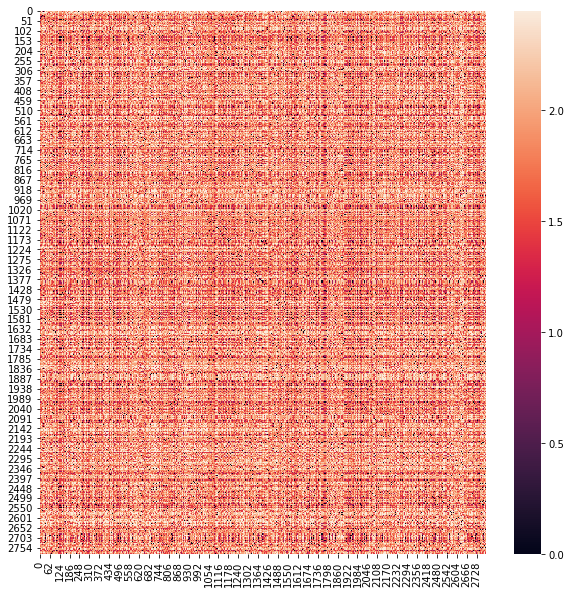

In [8]:
pairwise_dist = pd.DataFrame(
    squareform(pdist(genres)),
    columns = genres.index,
    index = genres.index
)

plt.figure(figsize=(10,10))
sns.heatmap(
    pairwise_dist
)

In [11]:
#svd = TruncatedSVD(n_components=10).fit(genres)
#print(svd.explained_variance_ratio_)
#print(svd.components_)

pca = PCA(n_components=3).fit(genres)
components = pd.DataFrame(pca.transform(genres))
components.columns = ['component1','component2','component3']
print(pca.explained_variance_ratio_)

[0.20249019 0.18883961 0.1094039 ]


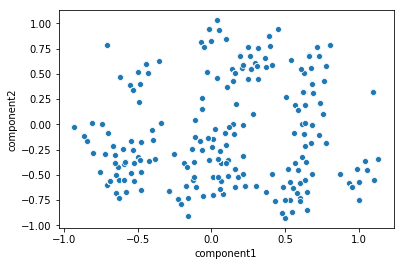

In [12]:
components.head(50)
sns.scatterplot(x=components['component1'], 
                y=components['component2']
                )

In [13]:
pca_clustering = KMeans(n_clusters=8).fit(components)
components['cluster'] = pca_clustering.labels_
components['cluster'].value_counts()

4    490
3    461
0    386
1    364
6    326
2    303
7    239
5    219
Name: cluster, dtype: int64

In [14]:
components.head(20)

,component1,component2,component3,cluster
0,0.300038,-0.609147,-0.977042,5
1,0.716064,0.765111,-0.153168,6
2,-0.644129,-0.502555,0.432699,7
3,-0.601883,-0.247211,-0.236973,4
4,-0.624916,-0.726340,0.305348,7
5,-0.720409,-0.294596,-0.354591,4
6,0.499920,-0.925129,0.490529,0
7,-0.168891,-0.609129,-0.539541,5
8,-0.720409,-0.294596,-0.354591,4
9,0.049212,0.935591,0.230337,3


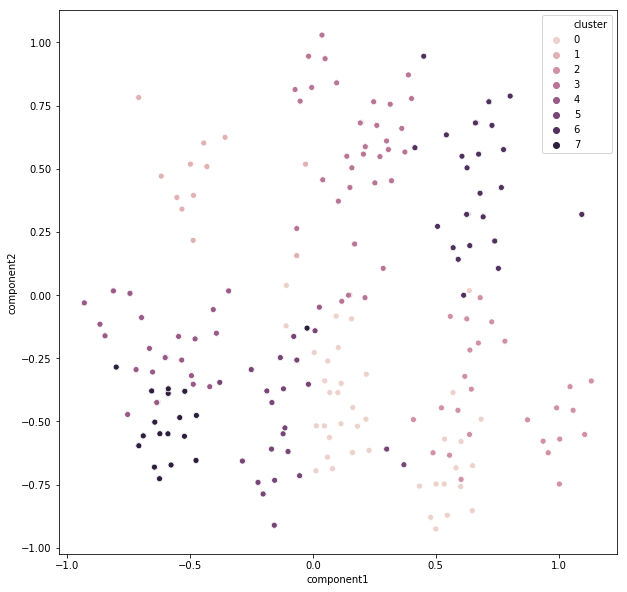

In [15]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=components['component1'], 
                y=components['component2'],
                hue=components['cluster'],
                legend='full')

In [16]:
movies['genre_cluster'] = components['cluster']
movies['genre_cluster'].value_counts()

4    490
3    461
0    386
1    364
6    326
2    303
7    239
5    219
Name: genre_cluster, dtype: int64

In [45]:
movies[genre_list + ['genre_cluster']].groupby(['genre_cluster']).mean()

,action,comedy,drama,adventure,biography,horror,crime,documentary,animation,romance,mystery,thriller,scifi,fantasy,family
genre_cluster,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.979079,0.000000,0.041841,0.221757,0.364017,0.020921,0.000000,0.029289,0.410042,0.523013,0.108787,0.075314,0.000000
1,0.429448,0.969325,0.000000,0.726994,0.006135,0.012270,0.165644,0.012270,0.401840,0.015337,0.006135,0.000000,0.027607,0.027607,0.131902
2,0.900990,0.000000,0.000000,0.894389,0.019802,0.023102,0.105611,0.003300,0.099010,0.009901,0.013201,0.075908,0.323432,0.283828,0.118812
3,0.000000,0.000000,0.997959,0.010204,0.297959,0.000000,0.128571,0.010204,0.008163,0.300000,0.022449,0.000000,0.016327,0.059184,0.055102
4,0.010989,1.000000,1.000000,0.035714,0.057692,0.005495,0.060440,0.005495,0.002747,0.359890,0.008242,0.002747,0.000000,0.035714,0.054945
5,0.340909,0.017677,0.000000,0.005051,0.000000,0.479798,0.212121,0.111111,0.000000,0.010101,0.300505,0.638889,0.138889,0.053030,0.010101
6,0.835616,0.000000,0.995434,0.328767,0.063927,0.009132,0.324201,0.000000,0.004566,0.009132,0.031963,0.114155,0.036530,0.073059,0.050228
7,0.000000,0.993348,0.000000,0.000000,0.015521,0.033259,0.128603,0.017738,0.046563,0.356984,0.024390,0.000000,0.026608,0.104213,0.155211


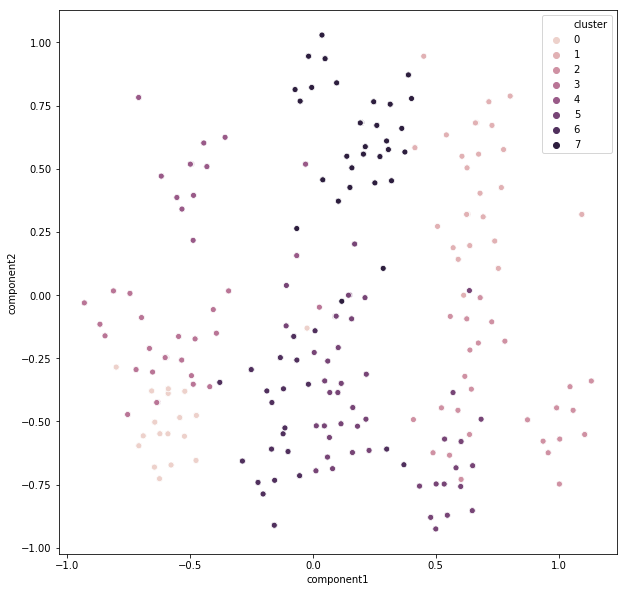

In [46]:
#components['genre_cluster'] = clustering.labels_
plt.figure(figsize=(10,10))
sns.scatterplot(x=components['component1'], 
                y=components['component2'],
                hue=components['cluster'],
                legend='full')

In [47]:
movies.head()

,primarytitle,domesticgross,productionbudget,runtimeminutes,releasedate,action,comedy,drama,adventure,biography,...,todd_phillips,warner_bros,universal,fox,buena_vista,sony,paramount,release_year,release_week,genre_cluster
0,"10,000 BC",94784201,105000000,109.0,2008-03-07,1,0,1,1,0,...,0,1,0,0,0,0,0,2008,10,6
1,102 Dalmatians,66941559,85000000,100.0,2000-11-22,0,1,0,1,0,...,0,0,0,0,1,0,0,2000,47,1
2,10 Cloverfield Lane,72082999,15000000,103.0,2016-01-04,0,0,1,0,0,...,0,0,0,0,0,0,1,2016,1,0
3,10 Days in a Madhouse,14616,12000000,111.0,2015-11-11,0,0,1,0,0,...,0,0,0,0,0,0,0,2015,46,3
4,10th & Wolf,54702,8000000,107.0,2006-08-18,0,0,1,0,0,...,0,0,0,0,0,0,0,2006,33,0


In [48]:
X = movies.drop(['primarytitle','releasedate','domesticgross'], axis=1)
y = movies['domesticgross']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

median_imputer = SimpleImputer(missing_values=np.nan, strategy='median', copy=False, fill_value=None)
median_imputer.fit(X_train)
X_train = median_imputer.transform(X_train)
X_test = median_imputer.transform(X_test)

scaler = MinMaxScaler(copy=False)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
gbm = GradientBoostingRegressor(random_state=0)
gbm.fit(X_train,y_train)
gbm.score(X_test,y_test)

0.5802635100084752

In [50]:
X = movies.drop(['primarytitle','releasedate','domesticgross']+genre_list, axis=1)
y = movies['domesticgross']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

median_imputer = SimpleImputer(missing_values=np.nan, strategy='median', copy=False, fill_value=None)
median_imputer.fit(X_train)
X_train = median_imputer.transform(X_train)
X_test = median_imputer.transform(X_test)

scaler = MinMaxScaler(copy=False)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
gbm = GradientBoostingRegressor(random_state=0)
gbm.fit(X_train,y_train)
gbm.score(X_test,y_test)

0.546104647615872

In [22]:
clustering = AgglomerativeClustering(n_clusters=8).fit(genres)
movies['genre_cluster'] = clustering.labels_
movies['genre_cluster'].value_counts()

0    582
3    418
1    414
2    327
6    314
7    262
4    240
5    231
Name: genre_cluster, dtype: int64

In [107]:
movies[genre_list + ['genre_cluster']].groupby(['genre_cluster']).mean()

,action,comedy,drama,adventure,biography,horror,crime,documentary,animation,romance,mystery,thriller,scifi,fantasy,family
genre_cluster,,,,,,,,,,,,,,,
0,0.021776,0.051926,0.944724,0.006700,0.279732,0.020101,0.301508,0.000000,0.001675,0.067002,0.150754,0.232831,0.068677,0.011725,0.000000
1,0.027027,0.737838,0.659459,0.083784,0.024324,0.008108,0.010811,0.005405,0.097297,0.083784,0.000000,0.002703,0.008108,0.291892,0.400000
2,0.803763,0.053763,0.158602,0.852151,0.032258,0.056452,0.002688,0.000000,0.083333,0.029570,0.029570,0.061828,0.346774,0.231183,0.094086
3,0.206349,0.835979,0.084656,0.005291,0.037037,0.005291,0.341270,0.198413,0.021164,0.037037,0.029101,0.002646,0.000000,0.000000,0.007937
4,0.000000,0.057554,0.262590,0.007194,0.000000,0.870504,0.028777,0.000000,0.000000,0.007194,0.496403,0.546763,0.097122,0.068345,0.000000
5,0.224138,1.000000,0.056034,1.000000,0.004310,0.000000,0.030172,0.000000,0.504310,0.004310,0.000000,0.000000,0.000000,0.000000,0.129310
6,1.000000,0.027950,0.456522,0.068323,0.027950,0.071429,0.500000,0.000000,0.000000,0.006211,0.046584,0.437888,0.068323,0.080745,0.003106
7,0.000000,0.725543,0.635870,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


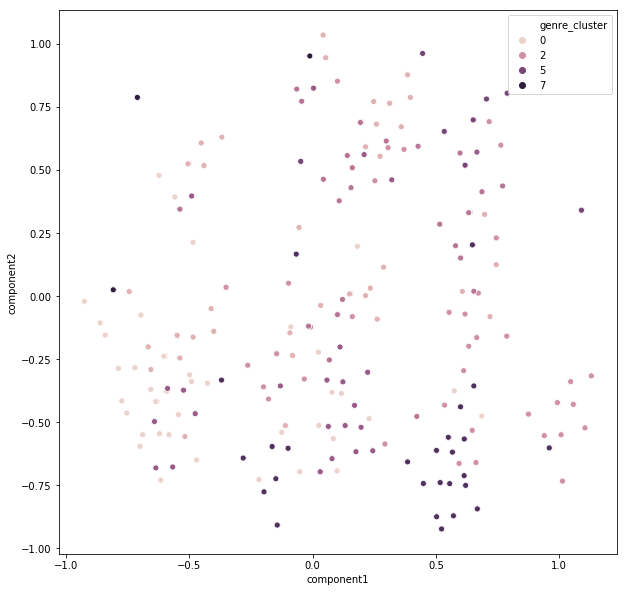

In [108]:
components['genre_cluster'] = clustering.labels_
plt.figure(figsize=(10,10))
sns.scatterplot(x=components['component1'], 
                y=components['component2'],
                hue=components['genre_cluster'])

In [112]:
clustering = KMeans(n_clusters=8).fit(genres)
movies['genre_cluster'] = clustering.labels_
movies['genre_cluster'].value_counts()

2    586
1    577
0    412
3    391
4    307
5    234
6    213
7    197
Name: genre_cluster, dtype: int64

In [113]:
movies[genre_list + ['genre_cluster']].groupby(['genre_cluster']).mean()

,action,comedy,drama,adventure,biography,horror,crime,documentary,animation,romance,mystery,thriller,scifi,fantasy,family
genre_cluster,,,,,,,,,,,,,,,
0,0.672330,0.002427,0.631068,0.004854,0.002427,0.007282,0.492718,0.000000,0.000000,0.000000,0.109223,0.660194,0.097087,0.036408,0.004854
1,0.003466,0.000000,0.894281,0.060659,0.000000,0.091854,0.149047,0.098787,0.008666,0.254766,0.171577,0.012132,0.048527,0.107452,0.058925
2,0.150171,1.000000,0.377133,0.022184,0.011945,0.034130,0.215017,0.020478,0.003413,0.000000,0.020478,0.011945,0.025597,0.098976,0.114334
3,0.915601,0.132992,0.097187,0.938619,0.015345,0.015345,0.056266,0.000000,0.076726,0.007673,0.017903,0.063939,0.248082,0.209719,0.097187
4,0.013029,0.986971,0.433225,0.003257,0.000000,0.006515,0.029316,0.000000,0.000000,1.000000,0.003257,0.006515,0.006515,0.032573,0.029316
5,0.128205,0.008547,0.038462,0.004274,0.000000,0.931624,0.025641,0.000000,0.000000,0.004274,0.423077,0.594017,0.153846,0.064103,0.000000
6,0.028169,0.934272,0.000000,0.868545,0.004695,0.004695,0.032864,0.004695,0.727700,0.000000,0.004695,0.000000,0.018779,0.014085,0.276995
7,0.045685,0.106599,0.959391,0.030457,1.000000,0.000000,0.157360,0.035533,0.005076,0.055838,0.005076,0.025381,0.000000,0.005076,0.040609


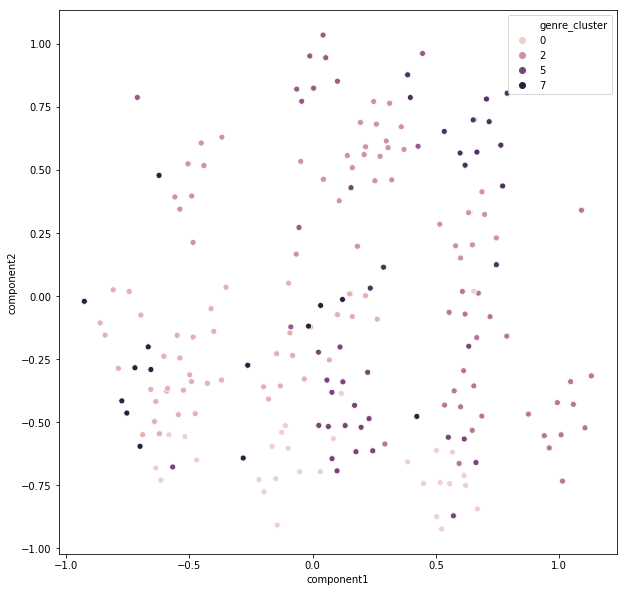

In [114]:
components['genre_cluster'] = clustering.labels_
plt.figure(figsize=(10,10))
sns.scatterplot(x=components['component1'], 
                y=components['component2'],
                hue=components['genre_cluster'])